# Pipeline for High-z Radio Galaxies 17: Radio detection classification with confirmed and predicted AGN

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and those predicted  
to be AGN by the initial Galaxy/AGN classification model (`ML_01.ipynb`).  

Being either AGN or galaxy will be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [135]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(stretch=PowerStretch(0.35))

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title, fontsize=14)
    plt.tight_layout()

In [9]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [10]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [11]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [12]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

In [13]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

***

## Reading data

In [14]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [149]:
save_plot_flag         = False
save_model_flag        = False
use_AGN_gal_model_flag = False
load_model_flag        = True

In [16]:
# use_5sigma = True  # use files with 5-sigma magnitude imputation

In [17]:
mqc_version = '7_4d'  # '7_2'

In [18]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [19]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR',\
                      'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'spCl'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [20]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [21]:
# full_catalog_df.describe()

#### Load previous model to create labels for unknown sources.

In [22]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index
final_indices     = confirmed_indices.union(unknown_indices)  # all

In [23]:
print(f'There are {np.sum(full_catalog_df.loc[:, "is_AGN"] == 1):,} confirmed AGN in this dataset.')

There are 30,395 confirmed AGN in this dataset.


In [24]:
if use_AGN_gal_model_flag:
    AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')  # From ML_16.ipynb

In [25]:
if use_AGN_gal_model_flag:
    AGN_pred_threshold = 0.5
    new_labels_train   = pyc.predict_model(AGN_gal_clf, data=full_catalog_df,\
                                           probability_threshold=AGN_pred_threshold,\
                                           raw_score=True).loc[:, 'Score_1']

In [26]:
if use_AGN_gal_model_flag:
    full_catalog_df['class'] = new_labels_train.copy()

In [27]:
if use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_gal'] == 1, 0)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_AGN'] == 1, 1)

#### Select only confirmed and highly likely AGN

In [28]:
if use_AGN_gal_model_flag:
    AGN_threshold = 0.95
    gal_threshold = 0.05

In [29]:
if use_AGN_gal_model_flag:
    filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)
    filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] < gal_threshold) & (full_catalog_df.loc[:, 'class'] > 0.00)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)

In [30]:
if not use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

In [31]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

In [32]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 1)]

In [33]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'class'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'class'] == 0)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 30,395 elements,
30,395 of them are marked as AGN, and, from them, 9,894 have confirmed radio detection.


---

## Possible correlations

In [34]:
print(full_catalog_df.columns.to_list())

['band_num', 'radio_detect', 'is_str', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2', 'class']


---

## Random seed

In [35]:
seed = 42

Create target

In [36]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Remove intermediate targets

In [37]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'class', 'is_str'])

## Split data: Test, Train, Validation

In [38]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2,\
     random_state=seed, stratify=full_catalog_df.loc[:, 'radio_detect'])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (30395, 39)
Data for Modeling (Train and Test): (24316, 39)
Unseen Data For Validation: (6079, 39)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [39]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [40]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [41]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [42]:
rsd_vals

z_y             465.633260
i_z             302.043157
r_i             168.345197
radio_detect    143.952309
g_r             142.709612
g_i             110.908568
w1_w2           102.837766
w2_w3            33.857496
band_num         21.841029
J_H              21.570060
H_K              20.015146
w3_w4            16.607659
ymag              5.963059
W1mproPM          5.810753
rmag              5.757490
zmag              5.742427
gmag              5.728570
imag              5.716503
W2mproPM          5.669804
i/K               5.268116
g/J               5.234680
w1/w4             5.173800
r/H               5.151636
w2/w4             5.030627
w1/w3             4.138570
y/W2              3.605276
z/W1              3.518495
W3mag             3.023767
i/y               2.539956
r/z               2.215555
NUVmag            2.194332
Hmag              1.869017
Jmag              1.820853
W4mag             1.787149
FUV/K             1.519242
Kmag              1.340516
FUVmag            0.764537
J

In [43]:
correlation    = norm_train_test_df.corr()

In [44]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [45]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [46]:
target_feat    = 'radio_detect'

In [47]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [48]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [49]:
list_drop_corr

['Jmag',
 'i/K',
 'W2mproPM',
 'w2/w4',
 'Kmag',
 'w1/w4',
 'imag',
 'r/H',
 'g/J',
 'FUV_NUV',
 'gmag',
 'J/K',
 'zmag',
 'w1/w3',
 'W3mag',
 'rmag',
 'Hmag',
 'W1mproPM',
 'g_i']

In [50]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [51]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [52]:
corr_discard = norm_train_test_discard.corr()

In [53]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
ymag      w2_w3       0.736970
z_y       i/y         0.732143
ymag      band_num    0.678584
r/z       i_z         0.663001
w3_w4     ymag        0.641163
NUVmag    FUVmag      0.629334
y/W2      z/W1        0.628881
w2_w3     band_num    0.621424
r_i       r/z         0.601351
H_K       FUV/K       0.546561
ymag      H_K         0.520172
w3_w4     NUVmag      0.517503
          w2_w3       0.499516
H_K       w3_w4       0.478999
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

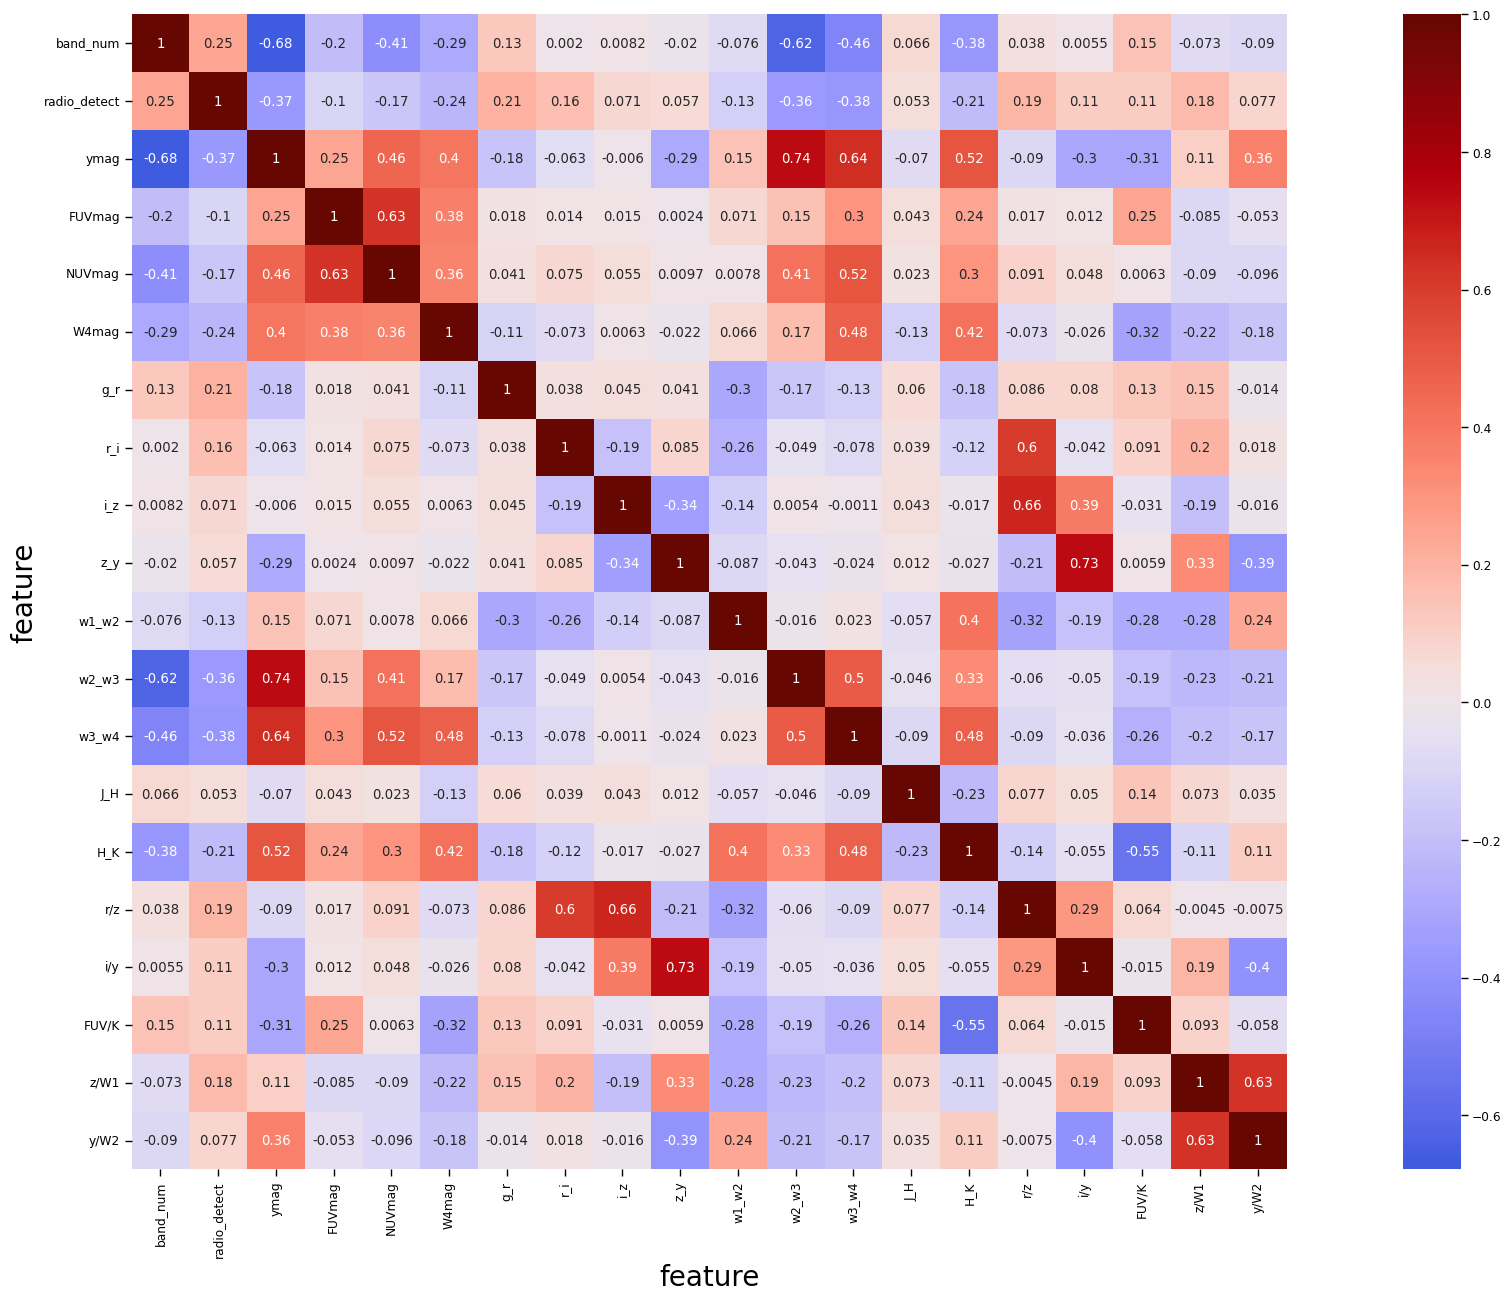

In [54]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [55]:
norm_train_test_discard.loc[:, 'radio_detect'] = norm_train_test_discard.loc[:, 'radio_detect'].astype(bool)

In [56]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [57]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y           
FUV/K     FUV/K           1.000000
band_num  ymag            0.491465
J_H       H_K             0.390293
NUVmag    FUVmag          0.352525
ymag      H_K             0.306450
w3_w4     radio_detect    0.305377
band_num  w2_w3           0.293498
FUV/K     H_K             0.276397
z_y       i/y             0.228403
ymag      radio_detect    0.223788
band_num  radio_detect    0.207456
ymag      w2_w3           0.196685
z_y       ymag            0.195337
band_num  H_K             0.186203
W4mag     radio_detect    0.178495
band_num  z_y             0.178244
w3_w4     w2_w3           0.172979
w2_w3     radio_detect    0.162261
i/y       z_y             0.151388
w2_w3     ymag            0.150613
dtype: float64

In [58]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [59]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [60]:
target_feat = 'radio_detect'

In [61]:
list_drop_pps = []

In [62]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [63]:
list_drop_pps

[]

In [64]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [65]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'radio_detect', random_seed=seed)

In [66]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,w3_w4,radio_detect,0.305377,classification,True,weighted F1,0.5564,0.691865,DecisionTreeClassifier()
1,ymag,radio_detect,0.223788,classification,True,weighted F1,0.5564,0.655672,DecisionTreeClassifier()
2,band_num,radio_detect,0.207456,classification,True,weighted F1,0.5564,0.648428,DecisionTreeClassifier()
3,W4mag,radio_detect,0.178495,classification,True,weighted F1,0.5564,0.635580,DecisionTreeClassifier()
4,w2_w3,radio_detect,0.162261,classification,True,weighted F1,0.5564,0.628379,DecisionTreeClassifier()
5,w1_w2,radio_detect,0.144597,classification,True,weighted F1,0.5564,0.620543,DecisionTreeClassifier()
6,J_H,radio_detect,0.127944,classification,True,weighted F1,0.5564,0.613156,DecisionTreeClassifier()
7,H_K,radio_detect,0.123038,classification,True,weighted F1,0.5564,0.610979,DecisionTreeClassifier()
8,FUV/K,radio_detect,0.109316,classification,True,weighted F1,0.5564,0.604893,DecisionTreeClassifier()
9,r/z,radio_detect,0.101272,classification,True,weighted F1,0.5564,0.601324,DecisionTreeClassifier()


In [67]:
print(f'{len(full_catalog_df):,}')

30,395


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [68]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats.remove('FUVmag')  # After Boruta

In [69]:
feats_2_discard = list_drop_corr + list_drop_pps + ['FUVmag']

Boruta discards one feature.

In [70]:
exp_radio = pyc.setup(data=train_test_df, target='radio_detect', session_id=seed, silent=True,\
                      feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                      numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                      transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                      normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,radio_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(24316, 39)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [71]:
pyc.get_config('X').columns

Index(['band_num', 'ymag', 'NUVmag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y',
       'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'r/z', 'i/y', 'FUV/K', 'z/W1',
       'y/W2'],
      dtype='object')

In [72]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [73]:
final_selection_clf  = ['dt', 'xgboost', 'rf', 'lightgbm', 'catboost', 'dummy']  # lightgbm is selected to be base learner.
n_models             = 5
top_model_radio = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort='Recall')  # 1:15 hour for used_models_clf
# top_model_radio = pyc.compare_models(n_select=n_models, exclude=['knn', 'qda'], sort='Recall')  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6786,0.6370,0.5186,0.5063,0.5123,0.2727,0.2728,0.2570
xgboost,Extreme Gradient Boosting,0.7587,0.7840,0.4991,0.6748,0.5737,0.4106,0.4198,8.7090
rf,Random Forest Classifier,0.7647,0.7900,0.4944,0.6943,0.5773,0.4207,0.4325,0.2760
lightgbm,Light Gradient Boosting Machine,0.7673,0.7976,0.4940,0.7025,0.5799,0.4258,0.4385,27.3550
catboost,CatBoost Classifier,0.7669,0.8000,0.4935,0.7013,0.5792,0.4247,0.4373,1.1060
dummy,Dummy Classifier,0.6745,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0150


Thus, we will select `lightgbm` as meta learner without it having the best Recall.

Thus, we stack the models.

In [74]:
# stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[1:], meta_model=top_model_radio[0], optimize='Recall', restack=True)
stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[0:3] + top_model_radio[4:],\
                                       meta_model=top_model_radio[3], optimize='Recall', restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7698,0.8157,0.5144,0.6985,0.5925,0.4372,0.4472
1,0.7732,0.8029,0.5108,0.7111,0.5945,0.4429,0.4546
2,0.7620,0.7994,0.4874,0.6905,0.5714,0.4134,0.4255
3,0.7656,0.7938,0.5126,0.6877,0.5874,0.4285,0.4375
4,0.7474,0.7672,0.4477,0.6667,0.5356,0.3712,0.3851
5,0.7573,0.7880,0.4838,0.6785,0.5648,0.4031,0.4141
6,0.7991,0.8240,0.5343,0.7789,0.6338,0.5019,0.5188
7,0.7638,0.8064,0.4982,0.6900,0.5786,0.4204,0.4312
8,0.7562,0.7968,0.4892,0.6725,0.5664,0.4026,0.4124


In [75]:
tuned_radio_clf = pyc.tune_model(stacked_model_radio, early_stopping='asha', optimize='Recall',\
                                 search_library='tune-sklearn', search_algorithm='random')  # 1h30

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7534,0.7793,0.5217,0.6509,0.5792,0.4077,0.4127
1,0.7550,0.7747,0.5361,0.6499,0.5875,0.4156,0.4194
2,0.7450,0.7681,0.5072,0.6357,0.5643,0.3872,0.3922
3,0.7620,0.7788,0.5397,0.6659,0.5962,0.4301,0.4349
4,0.7280,0.7403,0.4783,0.6036,0.5337,0.3453,0.3500
5,0.7280,0.7531,0.4747,0.6046,0.5319,0.3440,0.3490
6,0.7709,0.7976,0.5632,0.6783,0.6154,0.4542,0.4582
7,0.7438,0.7660,0.5181,0.6294,0.5683,0.3886,0.3923
8,0.7374,0.7627,0.5018,0.6192,0.5543,0.3710,0.3752


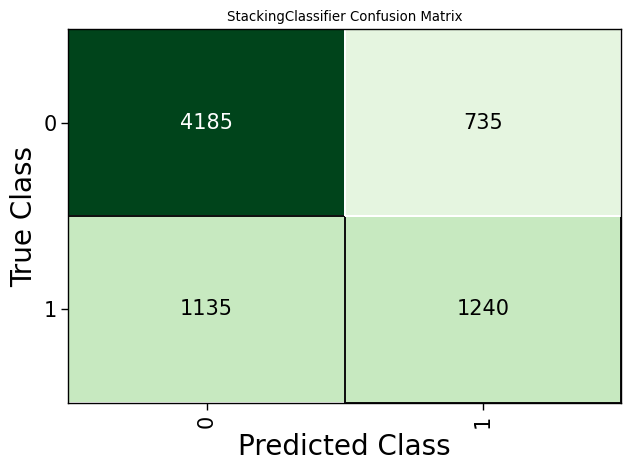

In [76]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

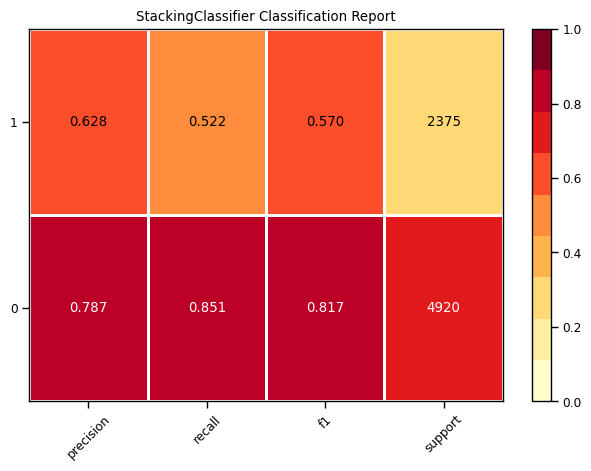

In [77]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

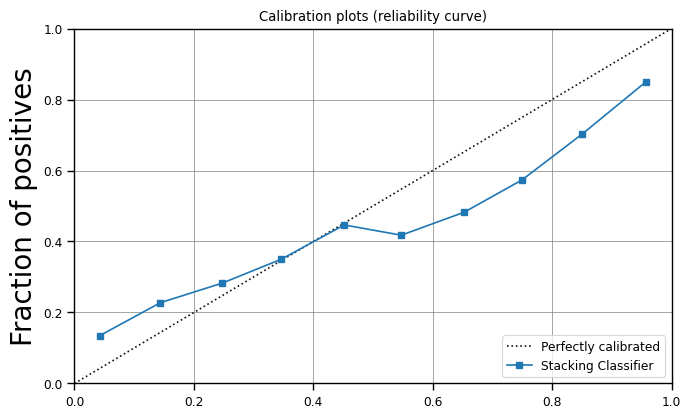

In [78]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

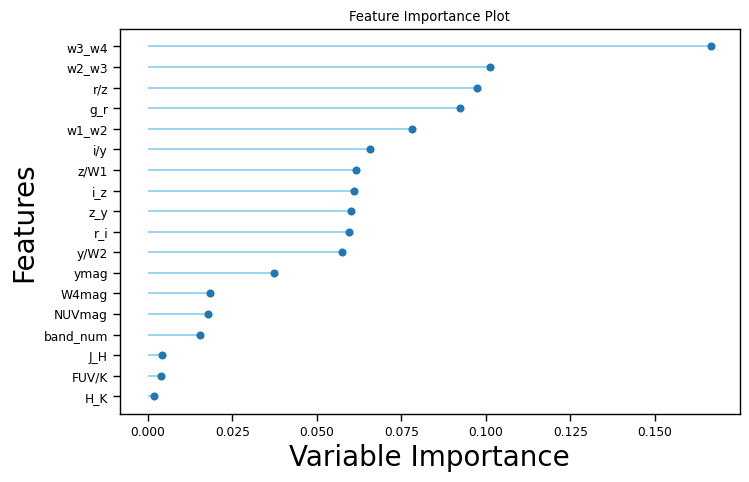

In [79]:
pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [80]:
pyc.plot_model(tuned_radio_clf.final_estimator, plot='parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.4
max_depth,-1
min_child_samples,1
min_child_weight,0.001
min_split_gain,0.4
n_estimators,180


In [81]:
plt.rcParams.update(plt.rcParamsDefault)

In [82]:
pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7437,0.7689,0.5221,0.6278,0.5701,0.3897,0.3931


,band_num,ymag,NUVmag,W4mag,g_r,r_i,i_z,z_y,w1_w2,w2_w3,...,H_K,r/z,i/y,FUV/K,z/W1,y/W2,radio_detect,Label,Score_0,Score_1
0,-0.012262,-0.135635,0.405591,0.258069,-0.750140,1.417777,0.791469,0.877970,-1.475136,1.022001,...,0.179141,1.614062,1.342764,-0.033564,0.039074,-1.291853,0,0,0.7537,0.2463
1,0.969687,-0.596803,-2.509998,0.258069,0.324493,-0.546475,-0.058849,0.364227,0.495513,-0.944180,...,0.179141,-0.429453,0.369145,-0.033564,0.015627,-0.062924,0,0,0.6703,0.3297
2,-0.012262,0.187670,0.405591,0.258069,-0.369059,0.410386,0.425775,0.622150,1.079311,0.605748,...,0.179141,0.594260,0.878798,-0.033564,-0.436000,-0.494592,0,0,0.8514,0.1486
3,-0.012262,-0.181096,0.405591,0.258069,-0.610008,-1.109655,-0.039771,0.535907,-0.470434,-0.800316,...,0.179141,-0.807583,0.527088,-0.033564,1.011568,0.479570,0,0,0.8812,0.1188
4,-0.433206,-0.253388,0.405591,0.258069,3.587390,2.149147,0.465194,0.186554,-1.863592,-0.716699,...,0.179141,2.024669,0.531247,-0.033564,1.341698,0.242064,1,0,0.5918,0.4082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7290,-0.012262,-0.603174,0.405591,0.258069,-0.210017,-0.439657,-0.762346,0.326741,0.424121,-0.105761,...,0.179141,-0.989289,-0.198268,-0.033564,-1.199538,-1.098034,0,1,0.3069,0.6931
7291,-0.012262,-0.158508,0.405591,0.258069,-0.423066,0.038248,-0.062443,0.049462,0.094649,0.783079,...,0.179141,-0.019251,0.037824,-0.033564,-1.350644,-1.141191,0,0,0.9758,0.0242
7292,-0.433206,-0.220985,0.405591,0.258069,3.243661,1.138794,0.390139,1.254788,-2.160347,1.317124,...,0.179141,1.114391,1.453449,-0.033564,0.425075,-1.637363,0,1,0.3001,0.6999
7293,0.457854,-0.627210,0.269245,0.258069,-0.116984,-0.666469,0.447471,-0.139991,-0.747384,-0.954786,...,0.179141,-0.077524,0.227559,-0.033564,0.136607,-0.106441,1,0,0.9254,0.0746


In [83]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7437,0.7689,0.5221,0.6278,0.5701,0.3897,0.3931


In [84]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pan

In [85]:
if save_model_flag:
    # pyc.save_model(final_radio_clf, 'models/classification_radio_detect_may_16_2022')  # Model (it will be saved with .pkl extension)
    # pyc.save_config('models/config_classification_radio_detect_may_16_2022')  # Configuration file (with included predictions)
    pyc.save_model(final_radio_clf, 'models/classification_radio_detect_ago_02_2022')  # Model (it will be saved with .pkl extension)
    # pyc.save_config('models/config_classification_radio_detect_ago_02_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [68]:
if load_model_flag:
    # final_radio_clf = pyc.load_model('models/classification_radio_detect_may_16_2022')
    final_radio_clf = pyc.load_model('models/classification_radio_detect_ago_02_2022')

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [86]:
estimators_list = get_base_estimators_names(final_radio_clf)

In [87]:
extended_data_radio = validation_df.loc[:, get_final_column_names(final_radio_clf, validation_df)].copy()
extended_idx_radio  = extended_data_radio.index
initial_cols_radio  = extended_data_radio.columns
extended_cols_radio = extended_data_radio.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_radio = extended_cols_radio.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [88]:
print('Running data pre-processing:\n')
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_radio_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_radio = method.transform(extended_data_radio)
extended_data_radio_df = pd.DataFrame(extended_data_radio, columns=extended_cols_radio, index=extended_idx_radio)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [89]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    importances_coef = final_radio_clf.named_steps['trained_model'].final_estimator_.feature_importances_
else:
    importances_coef = final_radio_clf.final_estimator_.feature_importances_

coef_meta_df = pd.DataFrame({'Feature': extended_cols_radio, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_radio))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [90]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_radio_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_radio_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_radio_clf.estimators
    estimators_list_ = final_radio_clf.estimators_

In [91]:
base_models_names = [model[0] for model in estimators_list]

In [92]:
coef_sorted_base_df = {}

In [93]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': np.abs(model_fit.coef_) *\
                                     extended_data_radio_df.loc[:, extended_cols_radio.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [94]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [95]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for dt...
Calculating for xgboost...
Calculating for rf...
Calculating for catboost...


dt              xgboost                   rf             catboost  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      w3_w4  16.969675     w3_w4  37.659294     w2_w3  10.289590     w2_w3   
1        r/z   9.809647     W4mag  16.817730     w3_w4   8.678842     w1_w2   
2      w2_w3   9.574991     w2_w3   6.817714      ymag   8.521897       g_r   
3        g_r   8.800945       r/z   4.445435       g_r   8.436829      z/W1   
4      w1_w2   8.356522       g_r   3.355649       r/z   8.109419       r/z   
5       z/W1   7.276496      ymag   3.121698     w1_w2   7.404889     w3_w4   
6        r_i   6.553306     w1_w2   3.078755      z/W1   7.390194       r_i   
7        i/y   6.318193      z/W1   2.804438       r_i   7.303240      ymag   
8        i_z   6.034743    NUVmag   2.767088       i/y   6.477740      y/W2   
9       y/W2   5.334695       r_i   2.475989       i_z   6.476353       z_y   
10       z_y   4.910706      y/W2   2.437537      y/W2   6.323478       i/y   
11      ymag   4.301452       i_z   2.407124       z_y   6.040961       i_z   
12     W4mag   1.869950  band_num   2.356999  band_num   3.102213  band_num   
13    NUVmag   1.587968       i/y   2.238513     W4mag   2.558653     W4mag   
14  band_num   1.547123       z_y   2.215117    NUVmag   1.453777    NUVmag   
15       H_K   0.267243     FUV/K   1.895135       H_K   0.502849     FUV/K   
16     FUV/K   0.263147       H_K   1.714803     FUV/K   0.484963       J_H   
17       J_H   0.223197       J_H   1.390985       J_H   0.444113       H_K   

               
   Importance  
0   11.521685  
1   10.122443  
2    8.576185  
3    8.224975  
4    8.156235  
5    7.832944  
6    6.794485  
7    5.628733  
8    5.614034  
9    5.462438  
10   5.107411  
11   4.891983  
12   3.546776  
13   3.472734  
14   2.234587  
15   1.032552  
16   0.942140  
17   0.837660

In [96]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,i_z,9.054753
1,g_r,8.020681
2,w1_w2,7.994167
3,r_i,7.755535
4,y/W2,7.742278
5,z/W1,6.960095
6,dt,6.787750
7,rf,6.655177
8,r/z,6.230943
9,i/y,6.191171


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w2_w3	11.445
w1_w2	10.011
g_r	8.526
w3_w4	8.219
z/W1	8.155
r/z	8.136
r_i	6.755
ymag	5.620
y/W2	5.587
z_y	5.431
i/y	5.105
i_z	4.894
W4mag	3.578
band_num	3.511
NUVmag	2.226
FUV/K	1.028
J_H	0.935
H_K	0.837


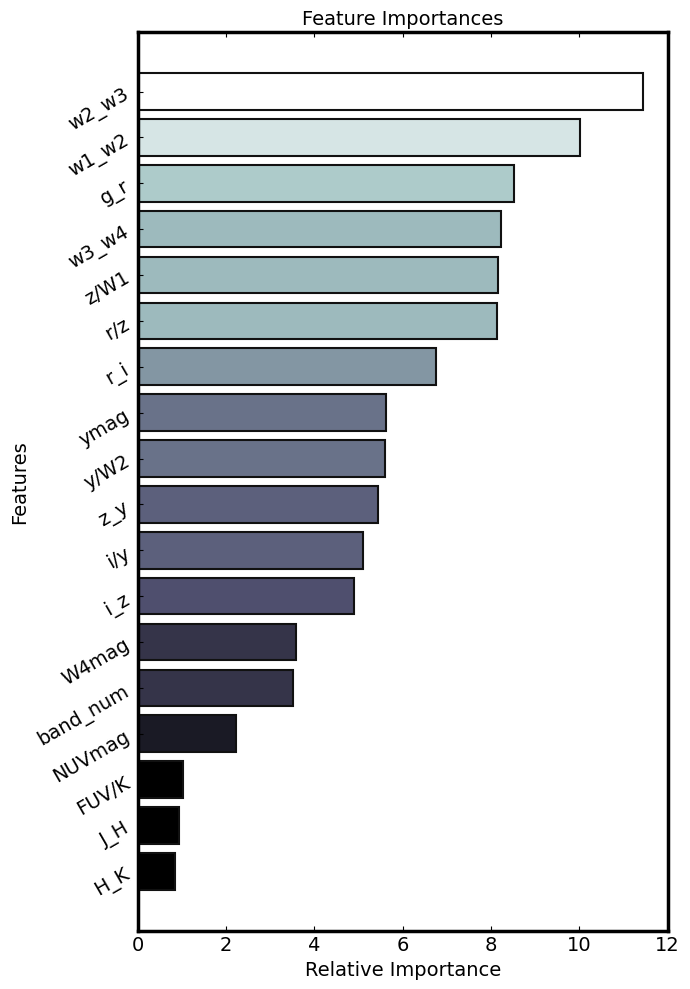

In [141]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_radio_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_radio_detect_05.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

---

In [98]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['radio_detect']), train_test_df.loc[:, 'radio_detect'], False, 'radio_detect'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['radio_detect']),
                train_test_df.loc[:, 'radio_detect'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

In [99]:
print(f'Size of train set is {len(train_data_df):,}')
print(f'Size of test set is  {len(test_data_df):,}')

Size of train set is 17,021
Size of test set is  7,295


#### Calculate optimal threshold for classification

In [100]:
radio_naive_threshold       = 0.5

In [101]:
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df, probability_threshold=radio_naive_threshold, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_data_df, probability_threshold=radio_naive_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_data_df,  probability_threshold=radio_naive_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df, probability_threshold=radio_naive_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7494653726,0.7763806554,0.5184436584,0.6428571429,0.5739860140,0.3994133940,0.4040484030


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8209270901,0.8746223704,0.6260822511,0.7807017544,0.6948948949,0.5703253622,0.5772826119


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8204249486,0.8738119287,0.6292703501,0.7758710348,0.6949231486,0.5696429556,0.5759144400


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8207764435,0.8743632953,0.6270372710,0.7792432093,0.6949033884,0.5701197355,0.5768670760


#### Naive threshold metrics.

In [102]:
cm_mat_val_naive = np.array([[np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                             [np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

In [103]:
cm_mat_train_naive = np.array([[np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
                               [np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [104]:
cm_mat_test_naive = np.array([[np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
                              [np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

In [105]:
cm_mat_train_test_naive = np.array([[np.sum(np.array(train_test_prediction_clf['radio_detect'] == 0) & np.array(train_test_prediction_clf['Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf['radio_detect'] == 0) & np.array(train_test_prediction_clf['Label'] == 1))],\
                                    [np.sum(np.array(train_test_prediction_clf['radio_detect'] == 1) & np.array(train_test_prediction_clf['Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf['radio_detect'] == 1) & np.array(train_test_prediction_clf['Label'] == 1))]])

In [106]:
MCC_val_naive           = MCC_from_CM(cm_mat_val_naive)
ACC_val_naive           = ACC_from_CM(cm_mat_val_naive)
F1_val_naive            = F1_from_CM(cm_mat_val_naive)
Recall_val_naive        = Recall_from_CM(cm_mat_val_naive)

MCC_train_naive         = MCC_from_CM(cm_mat_train_naive)
ACC_train_naive         = ACC_from_CM(cm_mat_train_naive)
F1_train_naive          = F1_from_CM(cm_mat_train_naive)
Recall_train_naive      = Recall_from_CM(cm_mat_train_naive)

MCC_test_naive          = MCC_from_CM(cm_mat_test_naive)
ACC_test_naive          = ACC_from_CM(cm_mat_test_naive)
F1_test_naive           = F1_from_CM(cm_mat_test_naive)
Recall_test_naive       = Recall_from_CM(cm_mat_test_naive)

MCC_train_test_naive    = MCC_from_CM(cm_mat_train_test_naive)
ACC_train_test_naive    = ACC_from_CM(cm_mat_train_test_naive)
F1_train_test_naive     = F1_from_CM(cm_mat_train_test_naive)
Recall_train_test_naive = Recall_from_CM(cm_mat_train_test_naive)

naive_scores_array            = np.array([[F1_train_naive,      MCC_train_naive,      Recall_train_naive,      ACC_train_naive],\
                                          [F1_test_naive,       MCC_test_naive,       Recall_test_naive,       ACC_test_naive],\
                                          [F1_train_test_naive, MCC_train_test_naive, Recall_train_test_naive, ACC_train_test_naive],\
                                          [F1_val_naive,        MCC_val_naive,        Recall_val_naive,        ACC_val_naive]])

In [107]:
naive_scores_df = pd.DataFrame(data=naive_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [108]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df)

,F1,MCC,Recall,ACC
Train,0.6949,0.5773,0.6261,0.8209
Test,0.6949,0.5759,0.6293,0.8204
Train+Test,0.6949,0.5769,0.6270,0.8208
Validation,0.5740,0.4040,0.5184,0.7495


In [109]:
validation_prediction_clf.loc[:, ['Score_0', 'Score_1']].describe()

,Score_0,Score_1
count,6079.000000,6079.000000
mean,0.686323,0.313677
std,0.306763,0.306763
min,0.000132,0.002956
25%,0.478079,0.056866
50%,0.809530,0.190470
75%,0.943134,0.521921
max,0.997044,0.999868


#### Calculate optimal threshold for prediction

Calculate ROC AUC values and plots.

In [110]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, 'radio_detect'], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

In [111]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.87462
Area under the curve (ROC) for test       = 0.87381
Area under the curve (ROC) for train+test = 0.87436
Area under the curve (ROC) for validation = 0.77638


In [112]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, 'radio_detect'], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

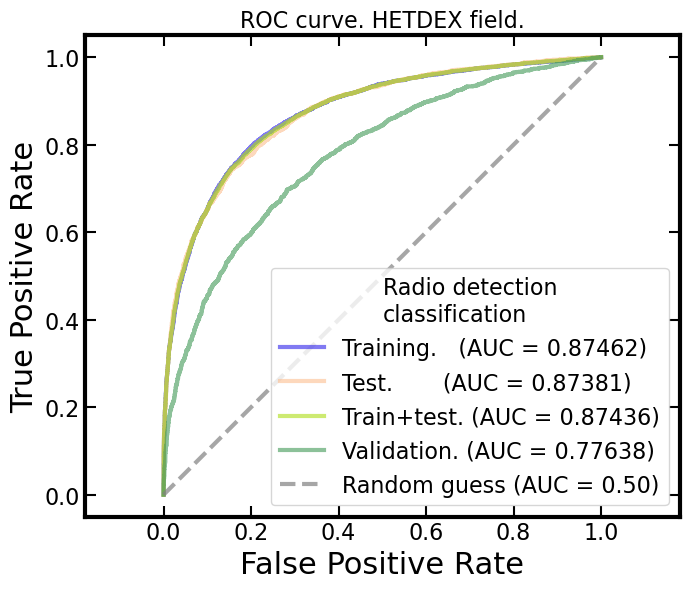

In [142]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+test. (AUC = {roc_auc_train_test:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=22)
ax1.set_ylabel('True Positive Rate', fontsize=22)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='Radio detection\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

##### Obtain optimal thresholds from each sub-set

In [114]:
opt_thres_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_thres_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_thres_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_thres_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [115]:
print(f'Optimal threshold from area under the curve (ROC) for training   = {opt_thres_train:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for test       = {opt_thres_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for train+test = {opt_thres_train_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for validation = {opt_thres_validation:.8e}')

Optimal threshold from area under the curve (ROC) for training   = 2.69467503e-01
Optimal threshold from area under the curve (ROC) for test       = 3.53344034e-01
Optimal threshold from area under the curve (ROC) for train+test = 3.05876696e-01
Optimal threshold from area under the curve (ROC) for validation = 2.65688317e-01


##### Precision-Recall curve

In [116]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, 'radio_detect'],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, 'radio_detect'],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, 'radio_detect'],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, 'radio_detect'],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [117]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_validation = auc(recall_validation, prec_validation)

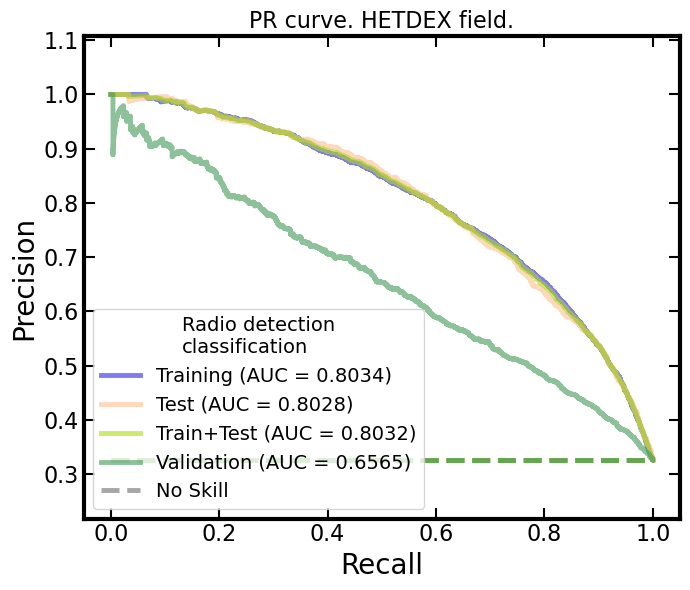

In [143]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test (AUC = {auc_pr_train_test:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, 'radio_detect'] == 1)      / len(train_prediction_clf.loc[:, 'radio_detect'])
no_skill_test       = np.sum(test_prediction_clf.loc[:, 'radio_detect'] == 1)       / len(test_prediction_clf.loc[:, 'radio_detect'])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, 'radio_detect'] == 1) / len(train_test_prediction_clf.loc[:, 'radio_detect'])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, 'radio_detect'] == 1) / len(validation_prediction_clf.loc[:, 'radio_detect'])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Radio detection\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/PR_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [119]:
fscore_train      = (2 * prec_train      * recall_train)      / (prec_train      + recall_train)
fscore_test       = (2 * prec_test       * recall_test)       / (prec_test       + recall_test)
fscore_train_test = (2 * prec_train_test * recall_train_test) / (prec_train_test + recall_train_test)
fscore_validation = (2 * prec_validation * recall_validation) / (prec_validation + recall_validation)

In [120]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [121]:
print(f'Optimal threshold from Precision-Recall curve for training   = {opt_t_PR_train:.8e}')
print(f'Optimal threshold from Precision-Recall curve for test       = {opt_t_PR_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for train+test = {opt_t_PR_train_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for validation = {opt_t_PR_validation:.8e}')

Optimal threshold from Precision-Recall curve for training   = 3.45872868e-01
Optimal threshold from Precision-Recall curve for test       = 3.54857403e-01
Optimal threshold from Precision-Recall curve for train+test = 3.45872868e-01
Optimal threshold from Precision-Recall curve for validation = 2.65688317e-01


#### Calibration curve

In [122]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, 'radio_detect'],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, 'radio_detect'],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

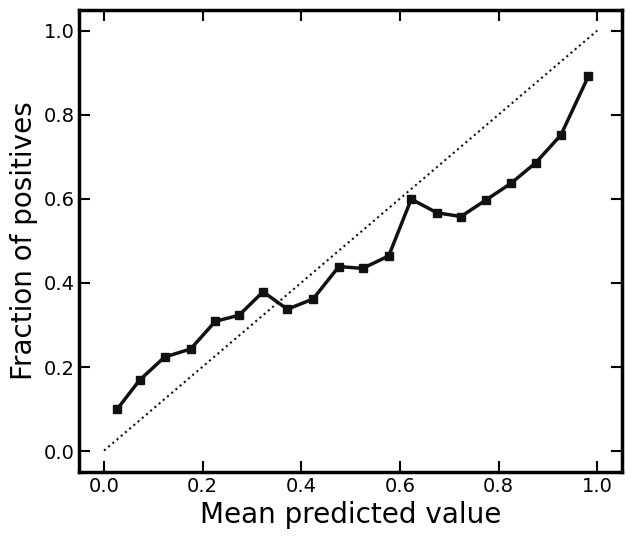

In [144]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='s', c='k', lw=2.5)
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

---

In [124]:
radio_pred_threshold = float(opt_t_PR_train_test) # 0.5

In [125]:
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_data_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_data_df,  probability_threshold=radio_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7272577727,0.7763806554,0.6250631632,0.5745471435,0.5987415295,0.3927173186,0.3935173126


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8134657188,0.8746223704,0.7465728716,0.7004569301,0.7227800576,0.5824399449,0.5831121606


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8098697738,0.8738119287,0.7456769296,0.6927899687,0.7182612228,0.5750759259,0.5759621123


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8123869057,0.8743632953,0.7463044852,0.6981444274,0.7214215926,0.5802274497,0.5809611085


Create confusion matrices.

In [126]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                       [np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
                         [np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
                        [np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

cm_mat_train_test = np.array([[np.sum(np.array(train_test_prediction_clf['radio_detect'] == 0) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf['radio_detect'] == 0) & np.array(train_test_prediction_clf['Label'] == 1))],\
                              [np.sum(np.array(train_test_prediction_clf['radio_detect'] == 1) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf['radio_detect'] == 1) & np.array(train_test_prediction_clf['Label'] == 1))]])

In [127]:
MCC_radio_train    = MCC_from_CM(cm_mat_train)
ACC_radio_train    = ACC_from_CM(cm_mat_train)
F1_radio_train     = F1_from_CM(cm_mat_train)
Recall_radio_train = Recall_from_CM(cm_mat_train)

MCC_radio_test    = MCC_from_CM(cm_mat_test)
ACC_radio_test    = ACC_from_CM(cm_mat_test)
F1_radio_test     = F1_from_CM(cm_mat_test)
Recall_radio_test = Recall_from_CM(cm_mat_test)

MCC_radio_train_test    = MCC_from_CM(cm_mat_train_test)
ACC_radio_train_test    = ACC_from_CM(cm_mat_train_test)
F1_radio_train_test     = F1_from_CM(cm_mat_train_test)
Recall_radio_train_test = Recall_from_CM(cm_mat_train_test)

MCC_radio_val    = MCC_from_CM(cm_mat_val)
ACC_radio_val    = ACC_from_CM(cm_mat_val)
F1_radio_val     = F1_from_CM(cm_mat_val)
Recall_radio_val = Recall_from_CM(cm_mat_val)

radio_scores_array      = np.array([[F1_radio_train,      MCC_radio_train,      Recall_radio_train,      ACC_radio_train],\
                                    [F1_radio_test,       MCC_radio_test,       Recall_radio_test,       ACC_radio_test],\
                                    [F1_radio_train_test, MCC_radio_train_test, Recall_radio_train_test, ACC_radio_train_test],\
                                    [F1_radio_val,        MCC_radio_val,        Recall_radio_val,        ACC_radio_val]])

In [128]:
radio_scores_array_df = pd.DataFrame(data=radio_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [129]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_array_df)

,F1,MCC,Recall,ACC
Train,0.7228,0.5831,0.7466,0.8135
Test,0.7183,0.5760,0.7457,0.8099
Train+Test,0.7214,0.5810,0.7463,0.8124
Validation,0.5987,0.3935,0.6251,0.7273


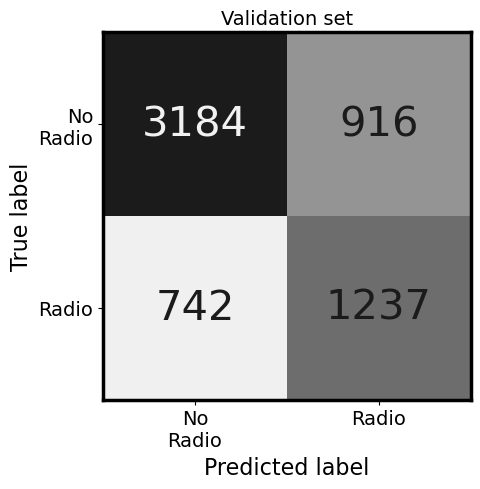

In [145]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

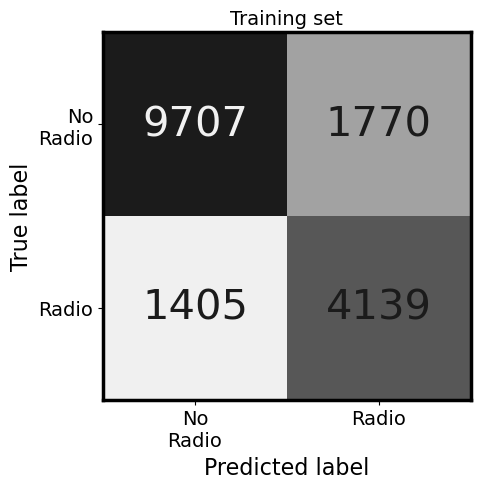

In [146]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

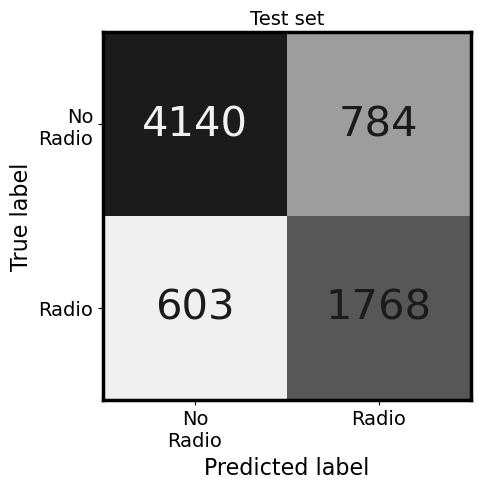

In [147]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

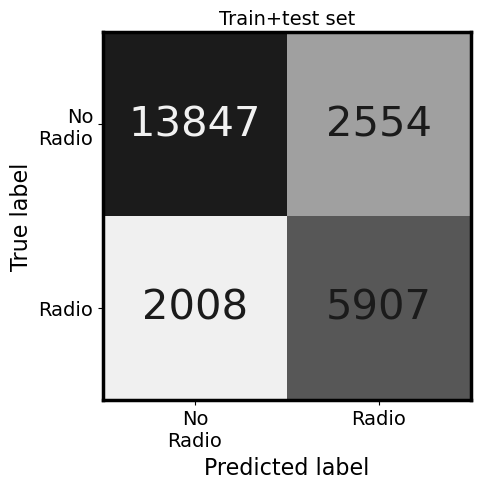

In [148]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()